# GAN example

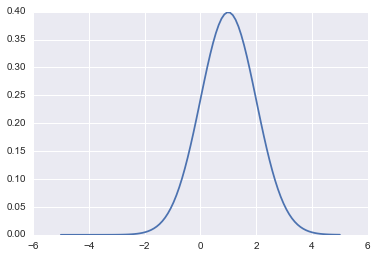

In [1]:
"""
vanilla gan
a mixture of eric jang and wiseodd
"""

PLOT_POINTS = 50000
X_RANGE = 5.0
Z_DIM = 1
X_BINS = 100

ITERATIONS = 301
BATCH_SIZE = 200
D_LEARNING_RATE = 1e-4
G_LEARNING_RATE = 1e-5

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
%matplotlib inline

# our sample distribution
mu,sigma=1,1
xs=np.linspace(-X_RANGE,X_RANGE, X_BINS)
plt.plot(xs, norm.pdf(xs,loc=mu,scale=sigma))

In [2]:
# MLP - reused for D_real, D_fake, and G
def mlp(input, output_dim):
    w1 = tf.get_variable("w1", [input.get_shape()[1], 16], initializer=tf.random_normal_initializer())
    b1 = tf.get_variable("b1", [16], initializer=tf.constant_initializer(0.0))
    w2 = tf.get_variable("w2", [16, 16], initializer=tf.random_normal_initializer())
    b2 = tf.get_variable("b2", [16], initializer=tf.constant_initializer(0.0))
    w3 = tf.get_variable("w3", [16,output_dim], initializer=tf.random_normal_initializer())
    b3 = tf.get_variable("b3", [output_dim], initializer=tf.constant_initializer(0.0))
    
    fc1 = tf.nn.tanh(tf.matmul(input,w1)+b1)
    fc2 = tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    logit = tf.matmul(fc2,w3)+b3
    return logit, [w1, b1, w2, b2, w3, b3]

X = tf.placeholder(tf.float32, [None, 1])
Z = tf.placeholder(tf.float32, [None, Z_DIM])

with tf.variable_scope("Generator"):
    G_logit, G_theta = mlp(Z,output_dim=1)
    #G_samples = tf.scalar_mul(X_RANGE, tf.nn.tanh(G_logit))
    tan = tf.tan(tf.scalar_mul(np.pi/2.0, tf.nn.tanh(G_logit)))
    G_samples = tf.maximum(tf.minimum(tan,X_RANGE), -X_RANGE)
    
    
with tf.variable_scope("Discriminator") as scope:
    # prob for guessing a true X to be true
    D_logit, D_theta = mlp(X,output_dim=1)
    D_real = tf.nn.sigmoid(D_logit)
    
    scope.reuse_variables()
    # prob for guessing a fake G(Z) to be true
    D_logit, D_theta = mlp(G_samples,output_dim=1)
    D_fake = tf.nn.sigmoid(D_logit)

# minimax game
D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))
# as per the paper’s suggestion, it’s better to
#    maximize tf.reduce_mean(tf.log(D_fake))
# instead of  
#    minimizing tf.reduce_mean(1 - tf.log(D_fake))

D_solver = tf.train.AdamOptimizer(D_LEARNING_RATE).minimize(D_loss, var_list=D_theta)
G_solver = tf.train.AdamOptimizer(G_LEARNING_RATE).minimize(G_loss, var_list=G_theta)


In [3]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [4]:
def sample_z(batch_size, dim, noise=True):
    if noise:
        return np.linspace(-1.0,1.0, batch_size).reshape((-1,1)) + np.random.random([batch_size, dim])*0.05
    else:
        return np.linspace(-1.0,1.0, batch_size).reshape((-1,1))
    #return np.random.uniform(-1.0,1.0,size=[batch_size, dim])

def sample_pdata(batch_size, dim):
    return np.random.normal(mu,sigma,[batch_size, dim])

sess.run(tf.global_variables_initializer())


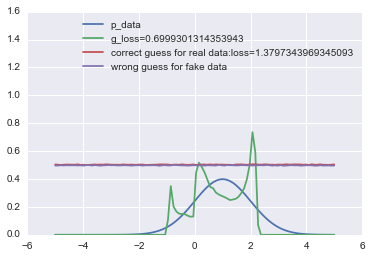

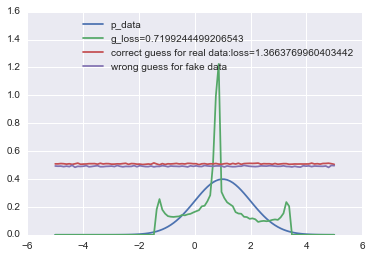

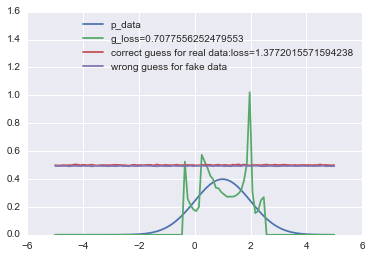

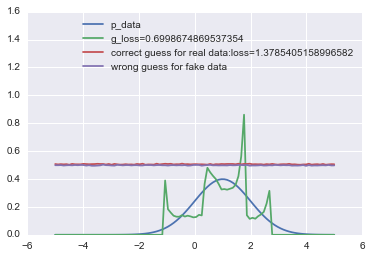

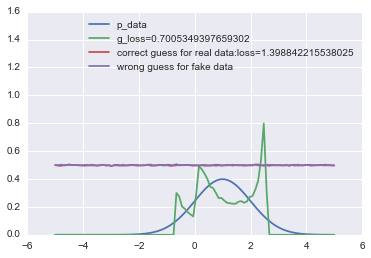

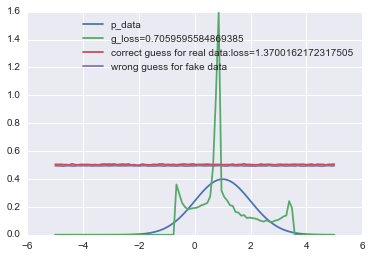

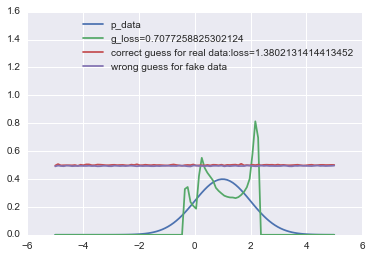

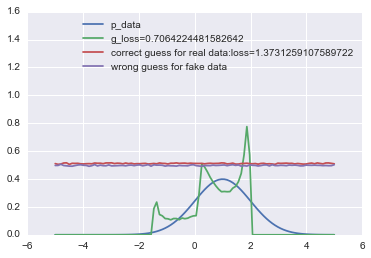

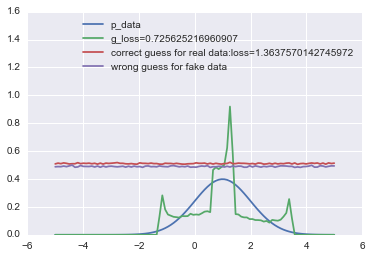

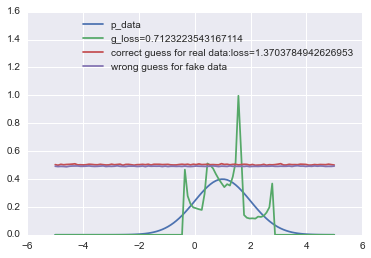

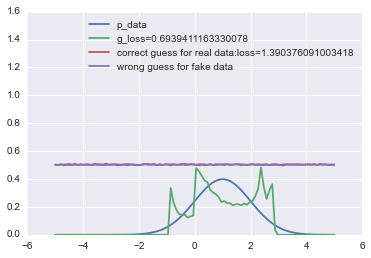

In [10]:
ITERATIONS = 10001
discrimin_iterations = 1

for i in range(ITERATIONS):
    
    for j in range(discrimin_iterations):
        discrim_loop_feed_dict = {
            # X is target distribution. We assume N(1,1)
            X: sample_pdata(BATCH_SIZE, 1),
            # z is prior. We assume Inif(-1,1)
            Z: sample_z(BATCH_SIZE, Z_DIM)
        }
        sess.run(D_solver, feed_dict=discrim_loop_feed_dict)
    
    feed_dict = {
        Z: sample_z(BATCH_SIZE, Z_DIM)
    }
    sess.run(G_solver, feed_dict=feed_dict)
    
    if i % 1000 == 0:
        feed_dict = {
            X: sample_pdata(PLOT_POINTS, 1),
            #Z: sample_z(PLOT_POINTS, Z_DIM, noise=False)
            Z: np.random.uniform(-1.,1.,[PLOT_POINTS, 1])
        }
        d_real, d_fake, d_loss = sess.run([D_real,D_fake,D_loss], feed_dict=feed_dict)
        g_samples, g_loss, g_logit = sess.run([G_samples, G_loss, G_logit], feed_dict=feed_dict)
        
        g_plot, _ = np.histogram(g_samples, bins=X_BINS, range=(-X_RANGE,X_RANGE), density=True)
        d_real_plot = np.average(d_real.reshape((-1, int(PLOT_POINTS/X_BINS))), axis=1) 
        d_fake_plot = np.average(d_fake.reshape((-1, int(PLOT_POINTS/X_BINS))), axis=1) 
        
        f,ax=plt.subplots(1)
        ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')
        ax.plot(xs, g_plot, label='g_loss={}'.format(g_loss))
        ax.plot(xs, d_real_plot, label='correct guess for real data:loss={}'.format(d_loss))
        ax.plot(xs, d_fake_plot, label='wrong guess for fake data')
        ax.set_ylim(0.,1.6)
        plt.legend()
        plt.show()
    

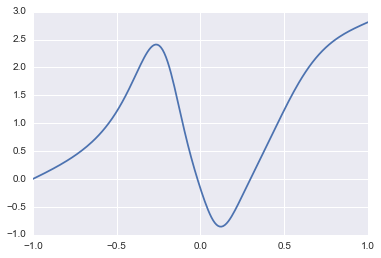

In [11]:
feed_dict = {
            X: sample_pdata(BATCH_SIZE, 1),
            Z: sample_z(BATCH_SIZE, Z_DIM, noise=False)
            #Z: np.random.uniform(-1.,1.,[BATCH_SIZE, 1])
        }
d_real, d_fake, d_loss = sess.run([D_real,D_fake,D_loss], feed_dict=feed_dict)
g_samples, g_loss, g_logit = sess.run([G_samples, G_loss, G_logit], feed_dict=feed_dict)

plt.plot(np.linspace(-1.,1.,BATCH_SIZE), g_samples)


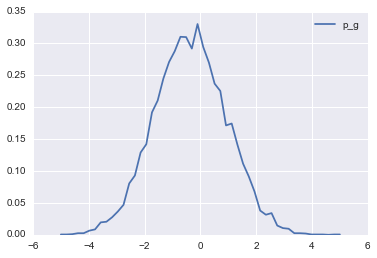

In [8]:
f,ax=plt.subplots(1)

gs = np.random.normal(mu,sigma,10000)

histg, _ = np.histogram(gs, bins = 50)
histg = histg/(2.0*X_RANGE*histg.sum()/50)

ax.plot(np.linspace(-5,5,50), histg, label='p_g')
plt.legend()

In [ ]:


plt.plot(sample_pdata(BATCH_SIZE, 1))
#plt.plot(sample_z(BATCH_SIZE, Z_DIM))

In [ ]:
np.pi